<a href="https://www.kaggle.com/code/odiradancan/carsalesprediction?scriptVersionId=116674747" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ann-car-sales-price-prediction/car_purchasing.csv


### 1. Importing module dependencies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer


### 2. Loading the dataset

In [3]:

car_sales = pd.read_csv('/kaggle/input/ann-car-sales-price-prediction/car_purchasing.csv', encoding = 'latin-1')
car_sales.head()

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


### 3. Data preprocessing

In [4]:
car_sales.describe()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.506000,46.241674,62127.239608,9607.645049,431475.713625,44209.799218
std,0.500465,7.978862,11703.378228,3489.187973,173536.756340,10773.178744
min,0.000000,20.000000,20000.000000,100.000000,20000.000000,9000.000000
25%,0.000000,40.949969,54391.977195,7397.515792,299824.195900,37629.896040
50%,1.000000,46.049901,62915.497035,9655.035568,426750.120650,43997.783390
75%,1.000000,51.612263,70117.862005,11798.867487,557324.478725,51254.709517
max,1.000000,70.000000,100000.000000,20000.000000,1000000.000000,80000.000000


In [5]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer name        500 non-null    object 
 1   customer e-mail      500 non-null    object 
 2   country              500 non-null    object 
 3   gender               500 non-null    int64  
 4   age                  500 non-null    float64
 5   annual Salary        500 non-null    float64
 6   credit card debt     500 non-null    float64
 7   net worth            500 non-null    float64
 8   car purchase amount  500 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 35.3+ KB


In [6]:
# handling missing vals
car_sales.isna().sum()

customer name          0
customer e-mail        0
country                0
gender                 0
age                    0
annual Salary          0
credit card debt       0
net worth              0
car purchase amount    0
dtype: int64

There are no missing values in the dataset

In [7]:
# identifying variables that are closely correlated to the dependent variable(carpurchase amount)
car_sales.corr()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount
gender,1.000000,-0.064481,-0.036499,0.024193,-0.008395,-0.066408
age,-0.064481,1.000000,0.000130,0.034721,0.020356,0.632865
annual Salary,-0.036499,0.000130,1.000000,0.049599,0.014767,0.617862
credit card debt,0.024193,0.034721,0.049599,1.000000,-0.049378,0.028882
net worth,-0.008395,0.020356,0.014767,-0.049378,1.000000,0.488580
car purchase amount,-0.066408,0.632865,0.617862,0.028882,0.488580,1.000000


There is no collinearity between the independent variables(predictors). When performing regression, we therefore can't use the lasso.

In [8]:
# checking correlation with response variable
car_corr = car_sales.corr()
car_corr['car purchase amount'].sort_values(ascending=False)

car purchase amount    1.000000
age                    0.632865
annual Salary          0.617862
net worth              0.488580
credit card debt       0.028882
gender                -0.066408
Name: car purchase amount, dtype: float64

age, annual salary and networth has strong positive correlation with the car purchase amount

In [9]:
car_sales.country.unique()

array(['Bulgaria', 'Belize', 'Algeria', 'Cook Islands', 'Brazil',
       'Liberia', 'Syria', 'Czech Republic', 'Armenia', 'Somalia',
       'Sint Maarten', 'Greenland', 'Nicaragua', 'Palestine, State of',
       'United Arab Emirates', 'Gabon', 'Tokelau', 'Portugal', 'Chad',
       'Iraq', 'Sudan', 'Angola', 'Nigeria', 'Madagascar', 'Macedonia',
       'Oman', 'Colombia', 'Namibia', 'Denmark', 'Dominican Republic',
       'Costa Rica', 'Botswana', 'Saint Pierre and Miquelon', 'France',
       'Senegal', 'Cambodia', 'Suriname', 'Turkey', 'Ethiopia',
       'French Guiana', 'Bhutan', 'Georgia', 'Mozambique', 'Nauru',
       'Timor-Leste', 'Djibouti', 'Argentina', 'Taiwan', 'Åland Islands',
       'Turks and Caicos Islands', 'Samoa', 'Vanuatu', 'Mongolia',
       'Sri Lanka', 'Guinea-Bissau', 'Egypt', 'Slovenia', 'Benin',
       'Cape Verde', 'Paraguay', 'Laos', 'Iceland', 'Viet Nam',
       'Marshall Islands', 'Germany', 'Kyrgyzstan', 'Mauritius', 'Gambia',
       'Reunion', 'Jordan', 'S

In [10]:
# expenditure by gender
car_sales.groupby('gender')['car purchase amount'].mean()

gender
0    44933.131928
1    43503.620644
Name: car purchase amount, dtype: float64

In [11]:
# dropping unnecessary columns
car_sales = car_sales.drop(columns = ['customer name', 'customer e-mail', 'country'], axis=1)
car_sales.head()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


Text(0.5, 1.0, 'Annual Salary against Car Purchase Amount')

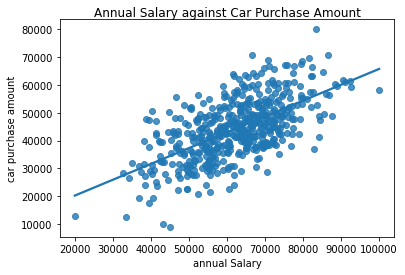

In [12]:
sns.regplot(x = 'annual Salary', y = 'car purchase amount', data = car_sales, ci = False)
plt.title('Annual Salary against Car Purchase Amount', pad=1)

Annual Salary against car purchase amount exhibits positive linearity

Text(0.5, 1.0, 'credit card debt against Car Purchase Amount')

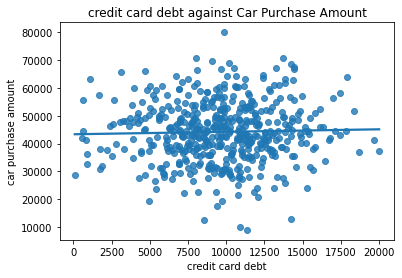

In [13]:
sns.regplot(x = 'credit card debt', y = 'car purchase amount', data = car_sales, ci=0)
plt.title('credit card debt against Car Purchase Amount')

credit card debt exhibits no linearity to car purchase amount 

Text(0.5, 1.0, 'Age against Car Purchase Amount')

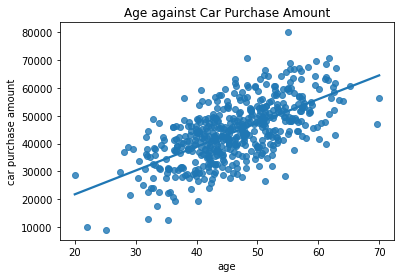

In [14]:
sns.regplot(x = 'age', y = 'car purchase amount', data = car_sales, ci=0)
plt.title('Age against Car Purchase Amount')

Age exhibits positive linearity to the car purchase amount 

Text(0.5, 1.0, 'net worth against Car Purchase Amount')

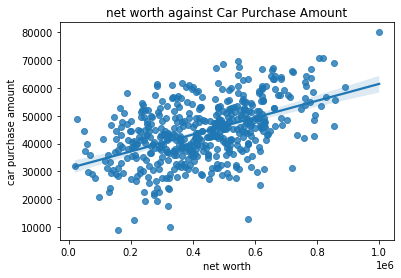

In [15]:
sns.regplot(x = 'net worth', y = 'car purchase amount', data = car_sales)
plt.title('net worth against Car Purchase Amount')

net worth of a client exhibits positive linearity. Possibly, a person with higher networth is likelier to buy more expensive cars.

Text(0.5, 1.0, 'Gender against Car Purchase Amount')

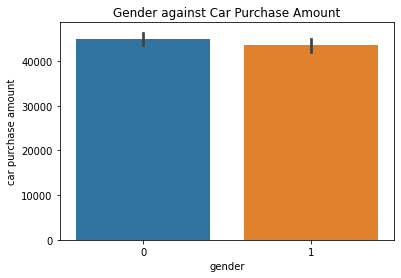

In [16]:
sns.barplot(x = 'gender', y = 'car purchase amount', data = car_sales)
plt.title('Gender against Car Purchase Amount')

Males record higher car purchase amounts compared to females. Males tend to buy more expensive cars, perhaps, for status.

In [17]:
car_sales.rename(columns={'annual Salary':'annual_salary', 'credit card debt':'credit_card_debt', 'net worth':'networth', 'car purchase amount':'car_cost'}, inplace=True)

In [18]:
car_sales.columns

Index(['gender', 'age', 'annual_salary', 'credit_card_debt', 'networth',
       'car_cost'],
      dtype='object')

### Creating a full prediction pipeline

In [19]:
# creating list of numerical features to encode
num_features = [1, 2, 3, 4]
num_transf = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

# creating list of categorical features to encode
cat_features = [0]
cat_transf = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

# joining the two pipelines
full_pipe = ColumnTransformer(transformers=[('num_encoder', num_transf, num_features), ('cat_encoder', cat_transf, cat_features)])

#modelling
regr = Pipeline(steps=[('full_pipe', full_pipe),
                       ('regressor', RandomForestRegressor(bootstrap = False, max_depth = 13, max_features='log2',
                                                          min_samples_leaf=1, min_samples_split=2,
                                                          n_estimators=18, random_state=11))])

# the best parameters from the GridSearchCV - See in the cell below.
# {'regressor__bootstrap': False,
#  'regressor__max_depth': 18,
#  'regressor__max_features': 'sqrt',
#  'regressor__min_samples_leaf': 2,
#  'regressor__min_samples_split': 2,
#  'regressor__n_estimators': 20}

# splitting the dataset
X = car_sales.iloc[:, :-1]
y = car_sales.iloc[:,-1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 41)
#fitting the  model
model = regr.fit(X_train, y_train)

#getting model score
print(regr.score(X_train, y_train))

0.9999147984932408


### Cross validating different regression models

#### (i) Random Forest Regressionn

In [20]:
car_sales.mean()

gender                   0.506000
age                     46.241674
annual_salary        62127.239608
credit_card_debt      9607.645049
networth            431475.713625
car_cost             44209.799218
dtype: float64

In [21]:
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rf_rmse = np.sqrt(-scores)
def get_scores(score):
    print(f'Scores: {rf_rmse}\nMean squared error:{rf_rmse.mean()}\nDeviation: _+{rf_rmse.std()}')

get_scores(rf_rmse)
print(f'model accuracy score: {model.score(X_train, y_train)}')

Scores: [2679.97733341 3208.49745604 3211.177368   4810.33614337 3116.13384537
 3821.61425761 3106.70800872 2515.50917569 3754.27893575 4303.69194971]
Mean squared error:3452.7924473673324
Deviation: _+679.7641469010297
model accuracy score: 0.9999147984932408


#### (ii)Decison Tree Regression performance 

In [22]:
tree_reg = Pipeline(steps=[('full_pipe', full_pipe), 
                           ('dt', DecisionTreeRegressor(max_depth=10,min_samples_split=2, min_samples_leaf=2))])
scores = cross_val_score(tree_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# best parameters from GriSearchCV
# {'dt__max_depth': 10,
#  'dt__max_features': None, None is the default
#  'dt__min_samples_leaf': 2,
#  'dt__min_samples_split': 2,
#  'dt__splitter': 'best'} best is the default



tree_rmse = np.sqrt(-scores)
def get_scores(score):
    print(f'Scores: {tree_rmse}\nMean squared error:{tree_rmse.mean()}\nDeviation: _+{tree_rmse.std()}')

get_scores(tree_rmse) 
tree_reg.fit(X_train, y_train)
print(f'model accuracy score: {tree_reg.score(X_train, y_train)}')

Scores: [3967.27170624 4004.71040601 4950.3553272  4650.60197942 4795.82856362]
Mean squared error:4473.753596494384
Deviation: _+409.5564098869383
model accuracy score: 0.9868429094179749


#### (iii) Linear Regression Performace 

In [23]:
lin_reg = Pipeline(steps=[('full_pipe', full_pipe), ('lr', LinearRegression())])
scores = cross_val_score(lin_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lin_rmse = np.sqrt(-scores)
def get_scores(score):
    print(f'Scores: {lin_rmse}\nMean squared error:{lin_rmse.mean()}\nDeviation: _+{lin_rmse.std()}')

get_scores(lin_rmse) 

lin_reg.fit(X_train, y_train)
lin_reg.score(X_train, y_train)

Scores: [1.40282309 1.52167763 1.44320693 1.61737806 1.50566392]
Mean squared error:1.4981499276836225
Deviation: _+0.07339114292635593


0.9999999813715645

Linear regression seems to have the least error as well as the highest model accuracy score without hyperparameter tuning.

#### (iv) Support Vector Regressor performance 

In [24]:
sv_reg = Pipeline(steps=[('full_pipe', full_pipe), ('svr', SVR())])
scores = cross_val_score(sv_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
svr_rmse = np.sqrt(-scores)
def get_scores(score):
    print(f'Scores: {svr_rmse}\nMean squared error:{svr_rmse.mean()}\nDeviation: _+{svr_rmse.std()}')

get_scores(svr_rmse) 


lin_reg.fit(X_train, y_train)
lin_reg.score(X_train, y_train)

Scores: [ 9758.86008531 11695.53766609 11605.92517561  9793.22335093
 10908.15113534]
Mean squared error:10752.339482656778
Deviation: _+842.5453918518891


0.9999999813715645

From the models tested, Linear regression had the least mean squared error and standard deviation compared to other models. SVR was the worst performing. There, Linear Regression in the best model to complete this task.

### Hyperparameter Tuning with GridSearchCV on Random Forest Regressor

In [25]:
param_grid = [{'regressor__bootstrap':[True, False],
              'regressor__n_estimators':[5, 10, 15, 20],
              'regressor__max_depth': [5, 10, 18],
              'regressor__max_features':['sqrt','log2'],
              'regressor__min_samples_leaf':[2,4, 6],
              'regressor__min_samples_split':[2,4,6]}]
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('full_pipe',
                                        ColumnTransformer(transformers=[('num_encoder',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         [1, 2,
                                                                          3,
                                                                          4]),
                                                                        ('cat_encoder',
                                                                         Pipeli

In [26]:
grid_search.best_params_

{'regressor__bootstrap': False,
 'regressor__max_depth': 18,
 'regressor__max_features': 'sqrt',
 'regressor__min_samples_leaf': 2,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 20}

### Hyperparameter tuning on Decision Tree Regression Model

In [27]:
param_grid = [{
              'dt__splitter':['best','random'],
              'dt__max_depth': [5, 10, 20],
              'dt__max_features':['sqrt','log2', None],
              'dt__min_samples_leaf':[2,4, 6],
              'dt__min_samples_split':[2,4,6]}]
grid_search = GridSearchCV(estimator=tree_reg, param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('full_pipe',
                                        ColumnTransformer(transformers=[('num_encoder',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         [1, 2,
                                                                          3,
                                                                          4]),
                                                                        ('cat_encoder',
                                                                         Pipeli

In [28]:
grid_search.best_params_

{'dt__max_depth': 10,
 'dt__max_features': None,
 'dt__min_samples_leaf': 2,
 'dt__min_samples_split': 2,
 'dt__splitter': 'best'}

In [29]:
grid_search.best_estimator_

Pipeline(steps=[('full_pipe',
                 ColumnTransformer(transformers=[('num_encoder',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [1, 2, 3, 4]),
                                                 ('cat_encoder',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0])])),
                ('dt',
                 DecisionTreeRegressor(max_depth=10, min_samples_leaf=2))])

In [30]:

def get_error_scores(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    error = y_pred-y_test
    rmse = np.sqrt(mse)
    print(f'mse:{mse}\nmae:{mae}\nrmse:{rmse}\nr2_score:{r2_score(y_test, y_pred)}\nstandard deviation:{error.std()}')


In [31]:
#creating a dataframe of y_actual and y_pred for the random forest model
rf_pred = regr.predict(X_test)
rf_df = pd.DataFrame({'y_actual':y_test, 'y_pred':rf_pred, 'error':rf_pred-y_test})
get_error_scores(y_test, rf_pred)

mse:12757071.372921903
mae:2601.09545736959
rmse:3571.7042672822035
r2_score:0.8850817541552364
standard deviation:3579.3997568855616


In [32]:
dt_pred = tree_reg.predict(X_test) 
get_error_scores(y_test, dt_pred)

mse:14660463.725167003
mae:3077.240428799848
rmse:3828.89850024351
r2_score:0.8679356158386765
standard deviation:3796.3470221749926


In [33]:
#performing prediction on the X test set
lr_pred = lin_reg.predict(X_test)
lr_df = pd.DataFrame({'y_actual':y_test, "y_pred":lr_pred, 'Error':y_test-lr_pred})

#evaluating model performance
get_error_scores(y_test, lr_pred)

mse:2.2039037445193723
mae:1.2387679655850479
rmse:1.4845550661795515
r2_score:0.999999980146795
standard deviation:1.4909961093102926


linear regression has the least mean absolute error amongst all the models tested.

In [34]:
lr_df[:10]

,y_actual,y_pred,Error
196,49721.31082,49721.783118,-0.472298
280,51730.17434,51732.053622,-1.879282
388,55174.98946,55173.501545,1.487915
379,37259.84386,37257.419915,2.423945
335,39911.61160,39911.381242,0.230358
275,38705.65839,38706.862210,-1.203820
244,52313.98392,52311.605638,2.378282
438,43898.27330,43897.595310,0.677990
239,44434.98419,44436.996582,-2.012392
493,47760.66427,47761.765244,-1.100974


### 6.Visualization

<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

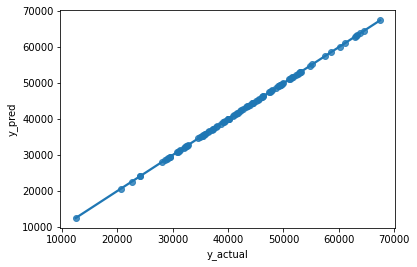

In [35]:
sns.regplot(data = lr_df, x = 'y_actual', y = 'y_pred', ci = False)